# Adversarial Examples for MNIST

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

先训练好一个网络

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    kwargs = {'num_workers': 1, 'pin_memory': True}
else:
    device = torch.device("cpu")
    kwargs = {}
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)
testset = datasets.MNIST('./data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=64, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True, **kwargs)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*4*4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x   # train 的时候用crossentropy，不需要softmax
    
    def predict(self, x):
        output = F.softmax(self.forward(x), dim=1)
        label = output.max(1)[1]
        prob = output[0,label]
        return (label, prob)

net = Net().to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
for epoch in range(5):
    for batch_idx, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        output = net(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()   
    print('Train Epoch: {:>2} \tLoss: {:.6f}'.format(epoch+1, loss.item()))

Train Epoch:  1 	Loss: 0.469047
Train Epoch:  2 	Loss: 0.060842
Train Epoch:  3 	Loss: 0.005437
Train Epoch:  4 	Loss: 0.014994
Train Epoch:  5 	Loss: 0.000661


显示图片

In [10]:
def imshow(images):
    img = torchvision.utils.make_grid(images)
    img = img * 0.3081 + 0.1307
    img = img.to("cpu")
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

## Non-Target

不要求与原图片相似，生成的是随机噪声.

反向传播后更新的是输入 `x` 而不是权重

In [29]:
torch.manual_seed(666)
x = torch.randn(1, 1, 28, 28)
y = torch.tensor([1])
n_iters = 5000
probs = []
for i in range(n_iters):
    net.zero_grad()
    x, y = x.to(device), y.to(device)
    x.requires_grad_()
    output = net(x)
    loss = criterion(output, y)
    loss.backward()
    x.detach_()
    x = x - 0.01*x.grad
    probs.append(net.predict(x)[1].item())

Text(0.5, 0, 'number of iterations')

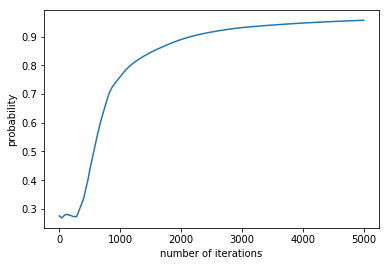

In [35]:
plt.plot(probs)
plt.ylabel("probability")
plt.xlabel("number of iterations")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


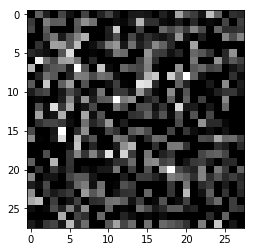

In [36]:
imshow(x)

## Target

Loss 增加了 `x` 和 `images` 的MSE

`generate_adversarial_examples` 函数可以根据输入的图片和指定的 label 生成相应的对抗样本。

In [167]:
def generate_adversarial_examples(net, device, images, label, lr=0.01, n_iters=1000, tol=0.7, log_interval=1000):
    x = images.clone()
    batch_size = x.shape[0]
    y = torch.tensor(np.repeat(label, batch_size), dtype=torch.int64)
    for i in range(n_iters):
        net.zero_grad()
        x, images, y = x.to(device), images.to(device), y.to(device)
        x.requires_grad_(True)
        output = net(x)
        loss = nn.CrossEntropyLoss()(output, y) + nn.MSELoss()(x, images)
        loss.backward()
        x.detach_()
        newx = x - lr * x.grad
        # 防止与原图片相差过大
        id = (newx-images).abs() < tol
        x[id] = newx[id]
        if (i + 1) % log_interval == 0:
            prob = (net(x).max(1)[1] == label).sum(dtype=torch.double) / batch_size
            print("Iter: {}\tLoss: {:.6f}\tProbability: {:>4.2f}%".format(i+1, loss.item(), prob*100))
    return x

In [298]:
train_loader = torch.utils.data.DataLoader(trainset,batch_size=64, shuffle=False, **kwargs)
dataiter = iter(train_loader)
images, _ = dataiter.next()
tols = [0.1, 0.3, 0.5, 0.7, 1]
examples = []
for tol in tols:
    print("\n----tol: {}----".format(tol))
    examples.append(generate_adversarial_examples(net, device, images, label=4, n_iters=2000, tol=tol))


----tol: 0.1----
Iter: 1000	Loss: 11.551777	Probability: 14.06%
Iter: 2000	Loss: 11.533780	Probability: 14.06%

----tol: 0.3----
Iter: 1000	Loss: 5.428458	Probability: 23.44%
Iter: 2000	Loss: 5.215477	Probability: 23.44%

----tol: 0.5----
Iter: 1000	Loss: 1.622085	Probability: 62.50%
Iter: 2000	Loss: 1.316296	Probability: 68.75%

----tol: 0.7----
Iter: 1000	Loss: 0.729856	Probability: 81.25%
Iter: 2000	Loss: 0.574642	Probability: 92.19%

----tol: 1----
Iter: 1000	Loss: 0.604789	Probability: 93.75%
Iter: 2000	Loss: 0.557644	Probability: 100.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


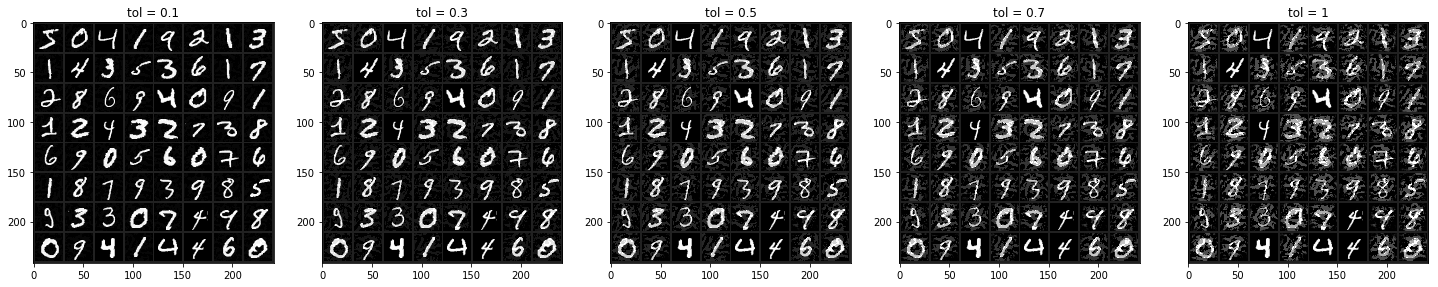

In [299]:
plt.figure(figsize=(25,10))
for i in range(len(examples)):
    plt.subplot(1, len(examples), i + 1)
    imshow(examples[i])
    plt.title("tol = {}".format(tols[i]))
plt.savefig("adversarial_examples.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


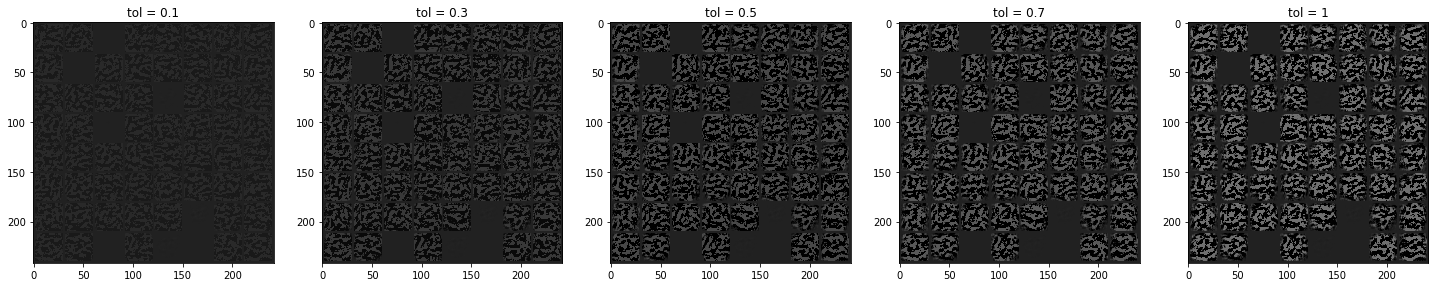

In [300]:
plt.figure(figsize=(25,10))
for i in range(len(examples)):
    plt.subplot(1, len(examples), i + 1)
    imshow(examples[i].to("cpu")-images)
    plt.title("tol = {}".format(tols[i]))
plt.savefig("adversarial_noise.png")

`tol`, `batch_size`, `n_iters` 这三个参数存在 trade-off。一般来说应该是先选好 `tol`，然后再根据收敛效果选 `batch_size` 和 `n_iters`